In [1]:
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 774.1 kB/s eta 0:00:00 0:00:01


In [ ]:
import datasets as ds
import transformers
import evaluate
import numpy as np
import sklearn as sk
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil

## Load Dataset

In [ ]:
dataset = ds.Dataset.from_csv("only_descriptions_balanced.csv")

Found cached dataset csv (/home/mnz/.cache/huggingface/datasets/csv/default-e3acdda924f5fb2d/0.0.0)


In [ ]:
dataset

Dataset({
    features: ['revision_id', 'page_title', 'descriptionOrLabel', 'revision_is_identity_reverted'],
    num_rows: 35090
})

In [ ]:
dataset = dataset.rename_column("descriptionOrLabel", "description")
dataset = dataset.rename_column("revision_is_identity_reverted", "label")

In [ ]:
dataset[0]

{'revision_id': 1691460685,
 'page_title': 'Q12177493',
 'description': 'norsk fagforening',
 'label': False}

## Preprocess dataset

In [ ]:
labels = ["not_reverted", "reverted"]

In [ ]:
label = ds.ClassLabel(num_classes=2, names=labels)
dataset = dataset.cast_column("label", label)

Loading cached processed dataset at /home/mnz/.cache/huggingface/datasets/csv/default-e3acdda924f5fb2d/0.0.0/cache-0e2f76bc3772eb45.arrow


In [ ]:
dataset.features

{'revision_id': Value(dtype='int64', id=None),
 'page_title': Value(dtype='string', id=None),
 'description': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_reverted', 'reverted'], id=None)}

In [ ]:
dataset[0]

{'revision_id': 1691460685,
 'page_title': 'Q12177493',
 'description': 'norsk fagforening',
 'label': 0}

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-multilingual-cased", use_fast=True)

In [ ]:
def preprocess(examples):
    return tokenizer(examples["description"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess, batched=True)

Loading cached processed dataset at /home/mnz/.cache/huggingface/datasets/csv/default-e3acdda924f5fb2d/0.0.0/cache-da8ba940430c3d45.arrow


In [ ]:
tokenized_dataset

Dataset({
    features: ['revision_id', 'page_title', 'description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 35090
})

In [ ]:
tokenized_dataset[0]

{'revision_id': 1691460685,
 'page_title': 'Q12177493',
 'description': 'norsk fagforening',
 'label': 0,
 'input_ids': [101, 16034, 12211, 10240, 82573, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
dataset = tokenized_dataset.train_test_split(
    test_size=0.2, stratify_by_column="label", seed=42
)

train_dataset = dataset["train"].train_test_split(
    test_size=0.1, stratify_by_column="label", seed=42
)

test_dataset = dataset["test"]

Loading cached split indices for dataset at /home/mnz/.cache/huggingface/datasets/csv/default-e3acdda924f5fb2d/0.0.0/cache-280b7c4e04775720.arrow and /home/mnz/.cache/huggingface/datasets/csv/default-e3acdda924f5fb2d/0.0.0/cache-cde9493933750268.arrow
Loading cached split indices for dataset at /home/mnz/.cache/huggingface/datasets/csv/default-e3acdda924f5fb2d/0.0.0/cache-ddf07c79d7dba61b.arrow and /home/mnz/.cache/huggingface/datasets/csv/default-e3acdda924f5fb2d/0.0.0/cache-25ea6422223fbd2a.arrow


In [ ]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['revision_id', 'page_title', 'description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25264
    })
    test: Dataset({
        features: ['revision_id', 'page_title', 'description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2808
    })
})

In [ ]:
test_dataset

Dataset({
    features: ['revision_id', 'page_title', 'description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7018
})

## Evaluation

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Training

In [ ]:
id2label = dict(enumerate(labels))
label2id = dict((label, idx) for idx, label in enumerate(labels))

In [ ]:
id2label

{0: 'not_reverted', 1: 'reverted'}

In [ ]:
label2id

{'not_reverted': 0, 'reverted': 1}

In [ ]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
training_args = transformers.TrainingArguments(
    output_dir="wikidata_description_only_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset["train"],
    eval_dataset=train_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/home/mnz/.conda/envs/2023-03-15T18.15.09_mnz/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=12632, training_loss=0.35453968594691815, metrics={'train_runtime': 1483.8022, 'train_samples_per_second': 68.106, 'train_steps_per_second': 8.513, 'total_flos': 1331909273334720.0, 'train_loss': 0.35453968594691815, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.47487351298332214,
 'eval_accuracy': 0.7991452991452992,
 'eval_runtime': 6.3073,
 'eval_samples_per_second': 445.198,
 'eval_steps_per_second': 55.65,
 'epoch': 4.0}

## Testing

In [ ]:
preds = trainer.predict(test_dataset)

In [ ]:
preds.metrics

{'test_loss': 0.4766296446323395,
 'test_accuracy': 0.8033627814192078,
 'test_runtime': 17.4665,
 'test_samples_per_second': 401.798,
 'test_steps_per_second': 50.268}

In [ ]:
softmax_predictions = np.apply_along_axis(
    lambda x: np.exp(x) / np.sum(np.exp(x)), 1, preds.predictions
)

In [ ]:
test_dict = {col: test_dataset[col] 
             for col in ('revision_id', 'page_title', 'description', 'label')}

test_dict["pred"] = np.argmax(softmax_predictions, axis=-1)
test_dict["score"] = softmax_predictions[:, 1] 

test_df = pd.DataFrame(test_dict)

In [ ]:
test_df

revision_id  page_title  \
0      1629079585  Q111784313   
1      1744340740       Q8425   
2      1742368132   Q13202847   
3      1544948481   Q12635699   
4      1517691916   Q12516360   
...           ...         ...   
7013   1812354441  Q107078602   
7014   1503263950   Q50398290   
7015   1781612764     Q581121   
7016   1705273612   Q13423853   
7017   1496956981    Q3023625   

                                            description  label  pred     score  
0     Street in Oberkotzau, district Hof, Upper Fran...      0     0  0.035973  
1     група людзей, зьвязаных міжсобку сталымі сувязямі      0     0  0.060821  
2                       venäjäntataarilainen taiteilija      1     0  0.042553  
3                                    tribu Shoshonéenne      0     0  0.105415  
4     stasiun kereta api di Kabupaten Semarang, Indo...      1     1  0.972231  
...                                                 ...    ...   ...       ...  
7013  free & open source map app on Android and iOS,...      0     1  0.992440  
7014                                        concept car      0     1  0.801918  
7015  Municipio de Nicaragua, Departemento Río San Juan      1     0  0.311252  
7016  Swedish YouTuber and video gamer commentator (...      1     1  0.995427  
7017               brtiský televizní seriál (2011–2014)      0     1  0.542993  

[7018 rows x 6 columns]

In [ ]:
test_df.groupby("label").describe()["score"]

count      mean       std       min       25%       50%       75%  \
label                                                                       
0      3525.0  0.232533  0.285736  0.010444  0.040386  0.095348  0.299849   
1      3493.0  0.771288  0.324879  0.012655  0.620915  0.963298  0.993245   

            max  
label            
0      0.997236  
1      0.997429

<AxesSubplot: title={'center': 'score'}, xlabel='label'>

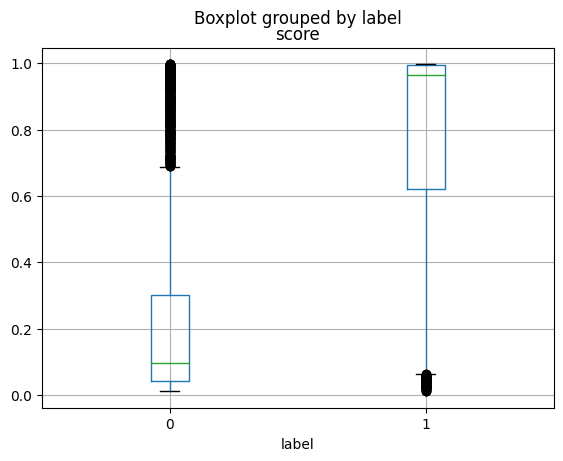

In [ ]:
test_df.boxplot(column="score", by="label")

In [ ]:
sk.metrics.confusion_matrix(test_df["label"], test_df["pred"])

array([[2912,  613],
       [ 767, 2726]])

In [ ]:
fpr, tpr, thresholds = sk.metrics.roc_curve(test_df["label"], test_df["score"])

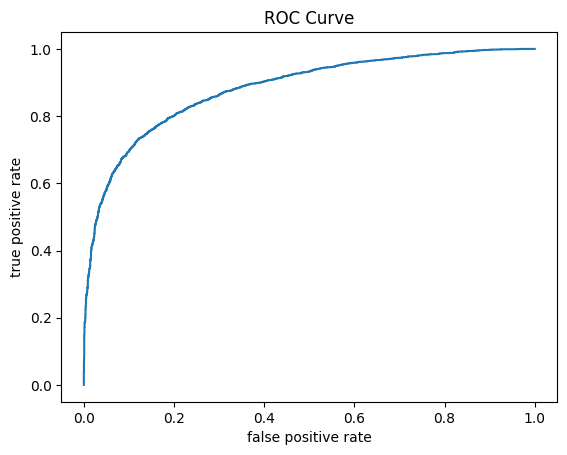

In [ ]:
plt.plot(fpr, tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
print(sk.metrics.classification_report(test_df["label"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3525
           1       0.82      0.78      0.80      3493

    accuracy                           0.80      7018
   macro avg       0.80      0.80      0.80      7018
weighted avg       0.80      0.80      0.80      7018



## Pipeline

In [ ]:
pipeline = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

In [ ]:
pipeline(["tribu Shoshonéenne", "yyyyyyyyyy"])

[{'label': 'not_reverted', 'score': 0.8945850133895874},
 {'label': 'reverted', 'score': 0.8870046734809875}]